In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Lambda, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import visualkeras
from glob import glob
import numpy as np
import cv2
import os


# Used to supress the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
pip install visualkeras

     -------------------------------------- 43.2/43.2 kB 299.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DATA LOADING PREPARATION AND VISUALISATION

In [6]:
folder_path ="C:\\Users\\Abhishek kumar\\Desktop\\brain_tumor_dataset"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')

dataset = []
label = []

for image_name in no_images:
    image = cv2.imread(folder_path + '/no/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((240,240))
    dataset.append(np.array(image))
    label.append(0)
    
    
for image_name in yes_images:
    image = cv2.imread(folder_path + '/yes/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((240,240))
    dataset.append(np.array(image))
    label.append(1)
    
    
dataset = np.array(dataset)
label = np.array(label)
print('Dataset Shape:',dataset.shape,'Label Shape:',label.shape)

Dataset Shape: (253, 240, 240, 3) Label Shape: (253,)


SPLIT DATA INTO TRAINING AND TESTING

In [7]:
X_train,X_test,y_train,y_test = train_test_split(dataset,label, test_size=0.2,shuffle=True, random_state=42)

In [8]:
X_train.shape

(202, 240, 240, 3)

In [9]:
X_test.shape

(51, 240, 240, 3)

In [10]:
# Rescale the image by dividing every pixel of image by 255

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

print("X_train",X_train.shape)
print("X_train samples",X_train.shape[0]) # 0 is index no
print("X_test",X_test.shape[0]) # 0 is index no

X_train (202, 240, 240, 3)
X_train samples 202
X_test 51


VISUALISE BOTH CLASSES IMAGES WITH THE HELP OF OPEN-CV

In [11]:
no = os.listdir(r"C:\\Users\\Abhishek kumar\\Desktop\\brain_tumor_dataset\\no")
print(no[:6])
yes = os.listdir(r"C:\\Users\\Abhishek kumar\\Desktop\\brain_tumor_dataset\\yes")
print(yes[:6])

['1 no.jpeg', '10 no.jpg', '11 no.jpg', '12 no.jpg', '13 no.jpg', '14 no.jpg']
['Y1.jpg', 'Y10.jpg', 'Y100.JPG', 'Y101.jpg', 'Y102.jpg', 'Y103.jpg']


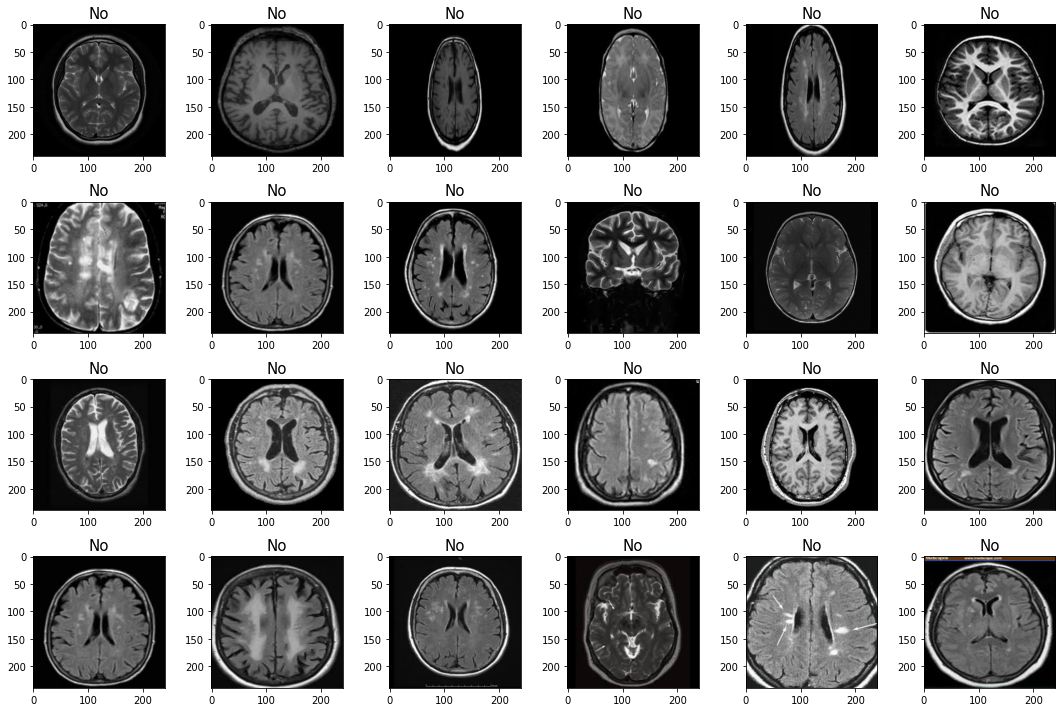

In [12]:
plt.figure(figsize=(15,10), facecolor='white')
for i in range(24):
    plt.subplot(4,6,i+1)
    img = cv2.imread(r"C:\\Users\\Abhishek kumar\\Desktop\\brain_tumor_dataset\\no" + '/' + no[i])
    resize_img = cv2.resize(img,(240,240))
    plt.imshow(resize_img)
    plt.title("No",fontsize=15)
plt.tight_layout()

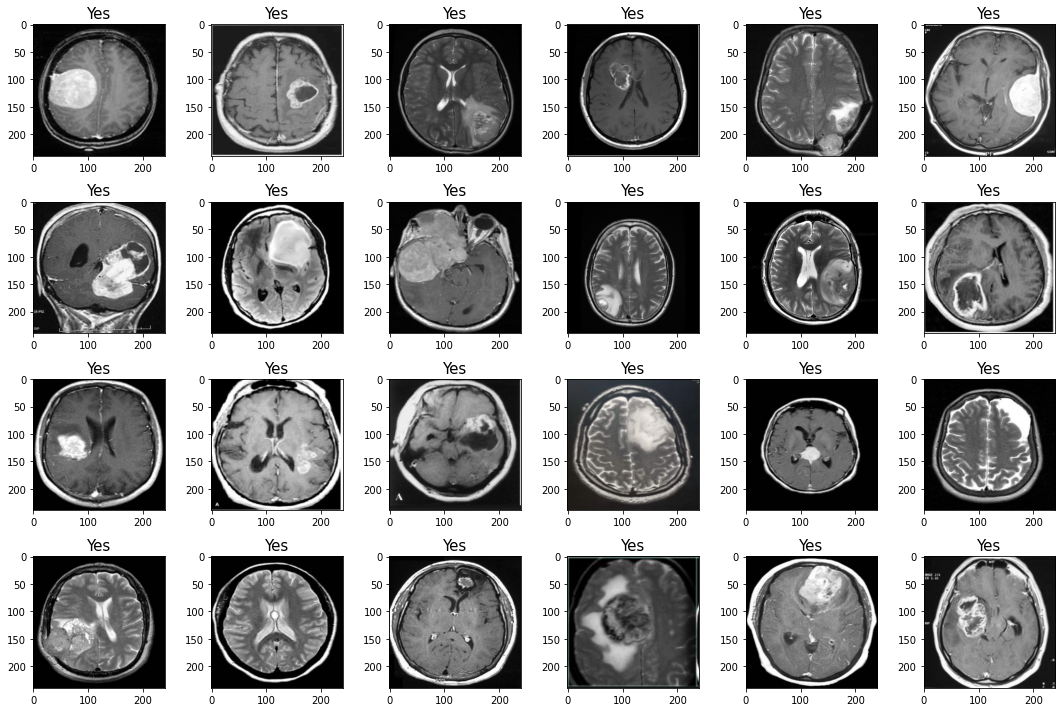

In [13]:
plt.figure(figsize=(15,10))
for j in range(24):
    plt.subplot(4,6,j+1)
    img = cv2.imread(r"C:\\Users\\Abhishek kumar\\Desktop\\brain_tumor_dataset\\yes" +  '/' + yes[j])
    resize = cv2.resize(img, (240,240))
    plt.imshow(resize)
    plt.title("Yes",fontsize=15)
plt.tight_layout()
    

BUILD CNN ARCHITECTURE

In [14]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(240,240,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                4

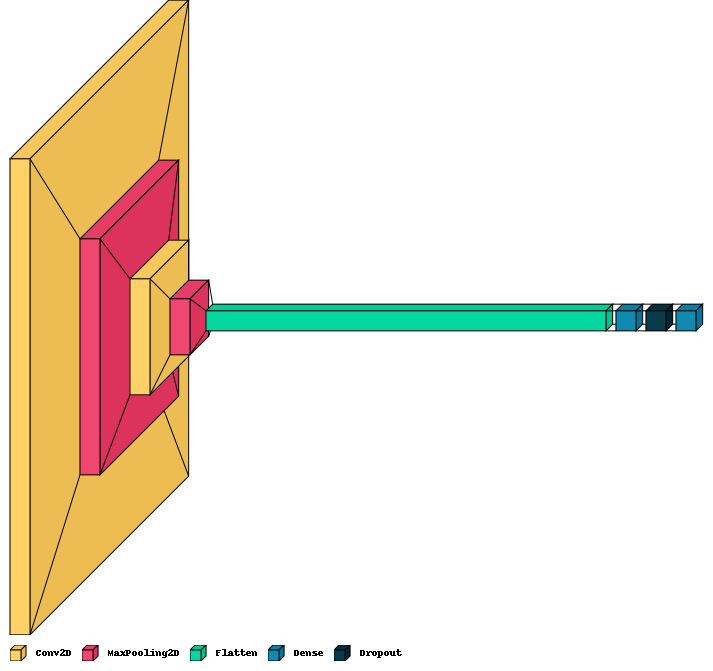

In [16]:
visualkeras.layered_view(model, legend=True)

COMPILE & TRAIN MODEL

In [17]:
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [18]:
# Compute the class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weights = dict(zip(np.unique(y_train),class_weights))
class_weights

{0: 1.294871794871795, 1: 0.8145161290322581}

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback = ModelCheckpoint(filepath='cnn_model.hdf5', save_best_only=True, monitor='val_loss',verbose=1)

history = model.fit(X_train,y_train, epochs=80, 
                    class_weight=class_weights, 
                    validation_data=(X_test,y_test), 
                    verbose=1,callbacks=callback)

Epoch 1/80
7/7 [==============================] - ETA: 0s - loss: 6.1561 - accuracy: 0.5644
Epoch 1: val_loss improved from inf to 4.75909, saving model to cnn_model.hdf5
7/7 [==============================] - 5s 275ms/step - loss: 6.1561 - accuracy: 0.5644 - val_loss: 4.7591 - val_accuracy: 0.6863
Epoch 2/80
7/7 [==============================] - ETA: 0s - loss: 4.1495 - accuracy: 0.7129
Epoch 2: val_loss improved from 4.75909 to 3.10825, saving model to cnn_model.hdf5
7/7 [==============================] - 1s 204ms/step - loss: 4.1495 - accuracy: 0.7129 - val_loss: 3.1083 - val_accuracy: 0.8431
Epoch 3/80
6/7 [========================>.....] - ETA: 0s - loss: 2.7240 - accuracy: 0.7344
Epoch 3: val_loss improved from 3.10825 to 1.91594, saving model to cnn_model.hdf5
7/7 [==============================] - 1s 168ms/step - loss: 2.6860 - accuracy: 0.7475 - val_loss: 1.9159 - val_accuracy: 0.8235
Epoch 4/80
6/7 [========================>.....] - ETA: 0s - loss: 1.8057 - accuracy: 0.7083


PLOTTING TRAINING AND VALIDATION LOSS & ACCURACY

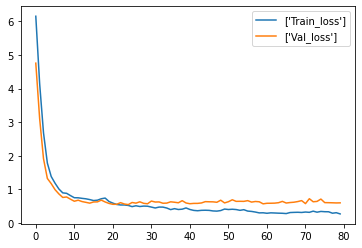

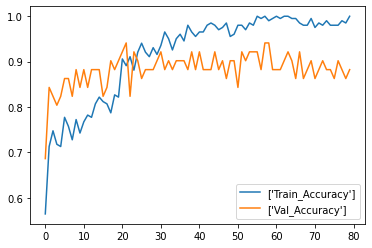

In [20]:
plt.plot(history.history['loss'],label=['Train_loss'])
plt.plot(history.history['val_loss'],label=['Val_loss'])
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],label=['Train_Accuracy'])
plt.plot(history.history['val_accuracy'],label=['Val_Accuracy'])
plt.legend()
plt.show()

MODEL EVALUATION

In [21]:
result = model.evaluate(X_test,y_test)
print("The Current Model Achived An Accuracy Of {}%".format(round(result[1]*100,2)))

2/2 [==============================] - 0s 36ms/step - loss: 0.6001 - accuracy: 0.8824
The Current Model Achived An Accuracy Of 88.24%


USE VGG19 TO GET BETTER RESULT

In [22]:
image_size = [240,240]
vgg = VGG19(input_shape=image_size + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 36s 0us/step


In [23]:
# Freeze the existing layer
for layer in vgg.layers:
    layer.trainable=False

In [24]:
# Adding more layers
x = Flatten()(vgg.output)
x = Dense(units=64, activation='relu', 
        kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
        bias_regularizer=regularizers.L2(1e-2),
        activity_regularizer=regularizers.L2(1e-3))(x)
prediction = Dense(1, activation='sigmoid')(x)
vgg_model = Model(vgg.input, outputs=prediction)

In [25]:
# Visualise the model summary
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

VISUALISE THE MODEL

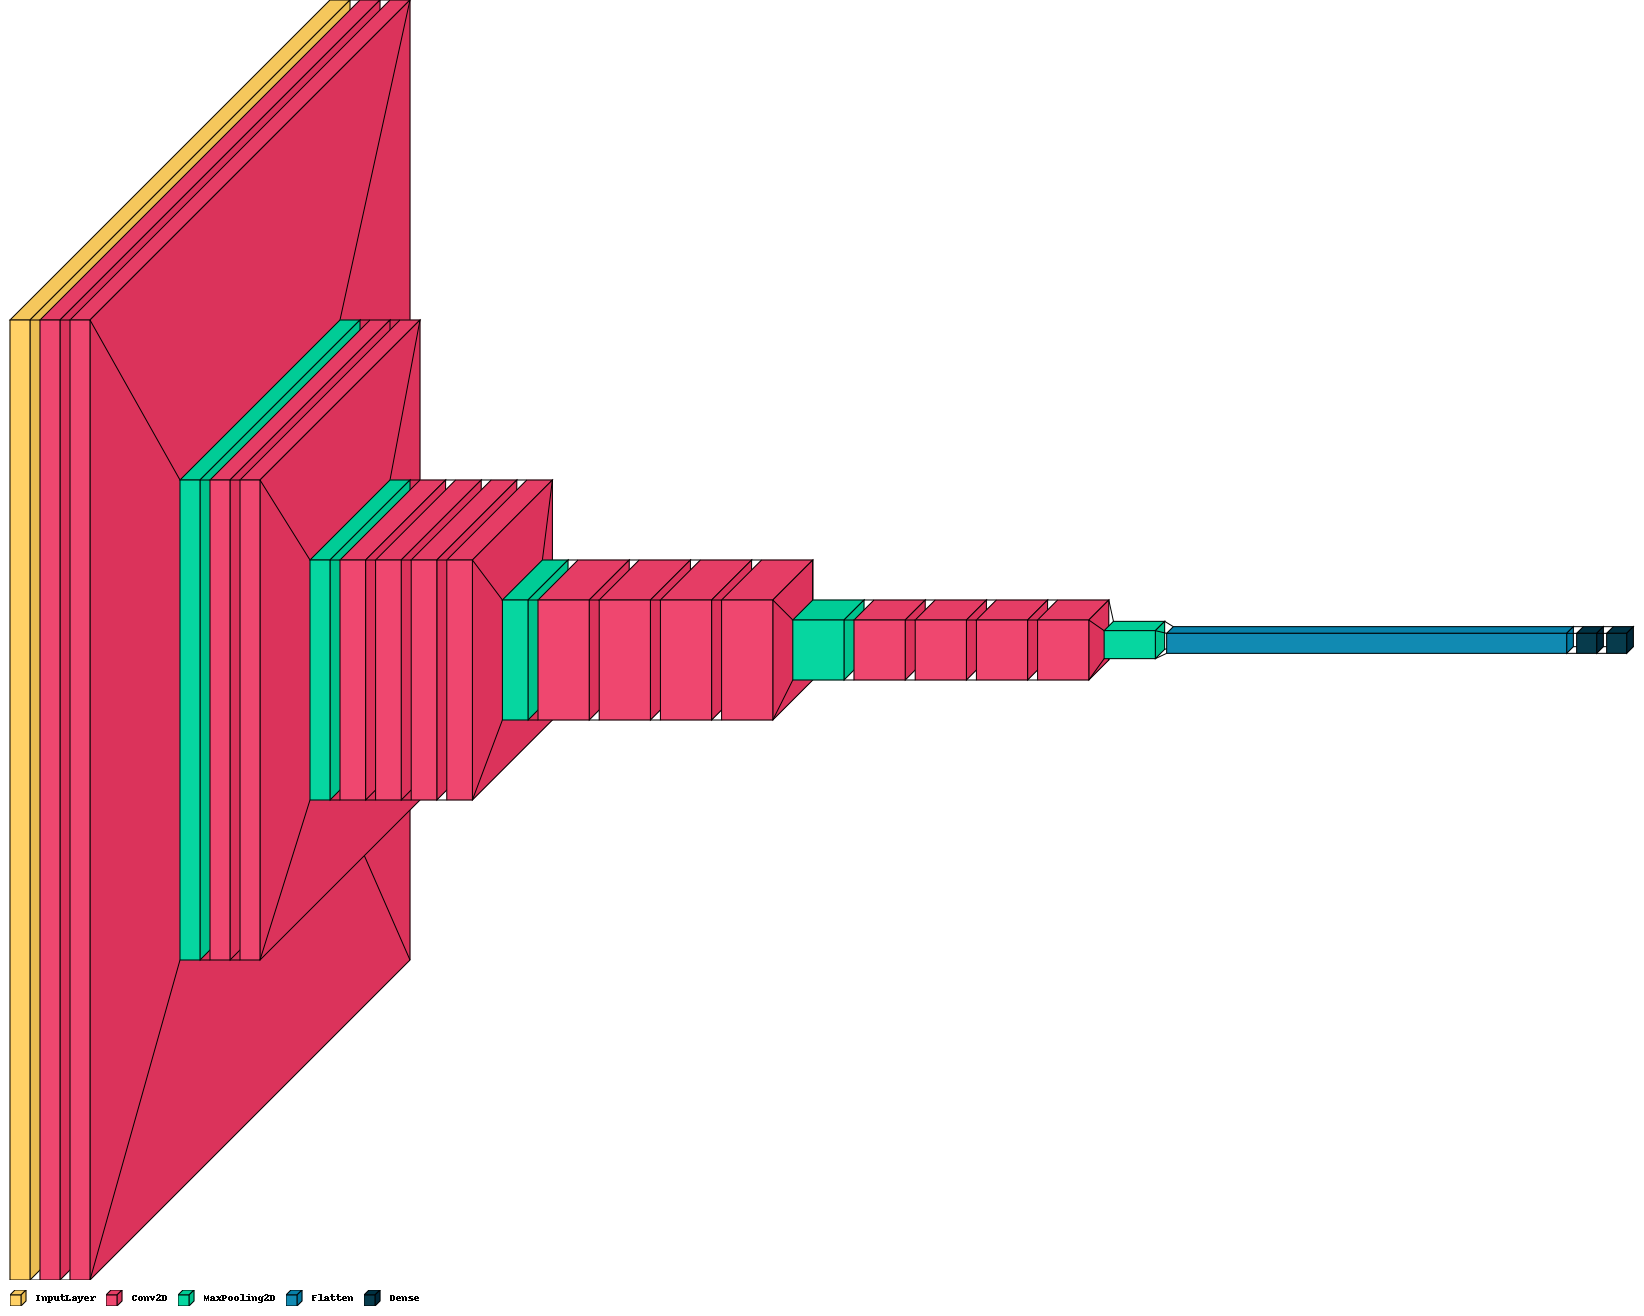

In [26]:
visualkeras.layered_view(vgg_model, legend=True)

COMPILE & TRAIN MODEL

In [27]:
vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# Fit model for training
history = vgg_model.fit(X_train,y_train, epochs=60,
             class_weight=class_weights,
             validation_data=(X_test,y_test),
             verbose=1)

Epoch 1/60
7/7 [==============================] - 46s 7s/step - loss: 12.0664 - accuracy: 0.4901 - val_loss: 7.1594 - val_accuracy: 0.6078
Epoch 2/60
7/7 [==============================] - 59s 9s/step - loss: 5.8588 - accuracy: 0.5644 - val_loss: 4.5154 - val_accuracy: 0.6078
Epoch 3/60
7/7 [==============================] - 62s 9s/step - loss: 4.3543 - accuracy: 0.6139 - val_loss: 3.8327 - val_accuracy: 0.6078
Epoch 4/60
7/7 [==============================] - 64s 9s/step - loss: 3.4910 - accuracy: 0.6139 - val_loss: 2.9855 - val_accuracy: 0.6078
Epoch 5/60
7/7 [==============================] - 64s 9s/step - loss: 2.8194 - accuracy: 0.7030 - val_loss: 2.4690 - val_accuracy: 0.7843
Epoch 6/60
7/7 [==============================] - 64s 9s/step - loss: 2.3476 - accuracy: 0.8020 - val_loss: 2.0842 - val_accuracy: 0.7451
Epoch 7/60
7/7 [==============================] - 66s 10s/step - loss: 2.0027 - accuracy: 0.7574 - val_loss: 1.8289 - val_accuracy: 0.8627
Epoch 8/60
7/7 [================

PLOTTING TRAINING, VALIDATION ACCURACY AS WELL AS LOSS

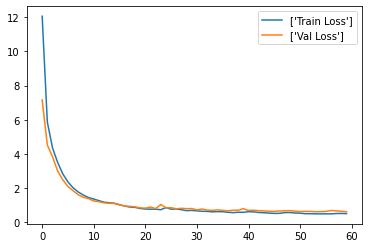

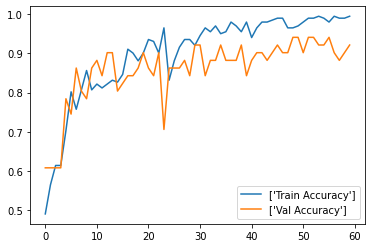

In [29]:
plt.plot(history.history['loss'], label=["Train Loss"])
plt.plot(history.history['val_loss'],label=['Val Loss'])
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label=["Train Accuracy"])
plt.plot(history.history['val_accuracy'],label=['Val Accuracy'])
plt.legend()
plt.show()

MODEL SAVING

In [30]:
vgg_model.save('VGG19_Model.h5')

MODEL EVALUATION

In [31]:
result = vgg_model.evaluate(X_test,y_test)
print("Result of VGG19 Model {}%".format(round(result[1]*100,2)))

2/2 [==============================] - 7s 2s/step - loss: 0.6061 - accuracy: 0.9216
Result of VGG19 Model 92.16%


In [32]:
predictions = vgg_model.predict(X_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 7s 3s/step


In [33]:
print(y_pred)

[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
